# Preprocessing and Sanity Checks

In [1]:
# Setup
import mne ## MNE-Python for analysing data
## below magic provides interactive plots in notebook
%matplotlib widget
from os import chdir
from os.path import join
import matplotlib.pyplot as plt ## for basic plotting
import matplotlib as mpl ## for setting default parameters
import pandas as pd
import numpy as np
import os

# All participants Pipeline

In [2]:
# CONFIGURATION

root_dir = '/work/MEG_data/workshop_data'
behaviour_path = join(root_dir, 'behavioural_logs')
output_dir = 'plots_PAS_sanity'
os.makedirs(output_dir, exist_ok=True)

subject_ids = ['0163', '0164', '0165','0166', '0167', '0168','0169', '0170']  # all subject IDs

# event info
event_ids = {"PAS1": 100, "PAS2": 200, "PAS3": 300}
comparisons = [("PAS2", "PAS1"), ("PAS3", "PAS2"), ("PAS3", "PAS1")]

# epoching parameters
tmin, tmax = -0.2, 0.55
baseline = (-0.2, 0)
reject = {'eog': 250e-6}



In [3]:
# PER-SUBJECT PROCESSING FUNCTION

def process_subject_final(sub_id):
    print(f"\n=== Processing {sub_id} ===")

    # create output folder per subject
    subj_out = join(output_dir, sub_id)
    os.makedirs(subj_out, exist_ok=True)

    # detect session folder
    sub_path = join(root_dir, sub_id)
    session_folder = [f for f in os.listdir(sub_path) if os.path.isdir(join(sub_path, f))][0]
    MEG_path = join(sub_path, session_folder)
    raw_fname = join(MEG_path, 'workshop_2025_raw.fif')

    # behavioural file
    behav_file = [f for f in os.listdir(behaviour_path) if f.startswith(sub_id)][0]
    behav_path = join(behaviour_path, behav_file)

    print(f"Loading MEG: {raw_fname}")
    print(f"Loading behaviour: {behav_path}")



    # Load MEG
    raw = mne.io.read_raw_fif(raw_fname, preload=True)
    raw.filter(l_freq=1, h_freq=40)

    # Find events
    # raw.info['sfreq'] is the sampling frequency
    events = mne.find_events(
        raw,
        stim_channel='STI101',      # adjust if your stim channel is different
        min_duration=1/raw.info['sfreq'],  # min duration in seconds
        shortest_event=1             # in samples
        )



    # Load behaviour
    behaviour = pd.read_csv(behav_path, index_col=False)
    behaviour['PAS_score'] = behaviour['subjective_response'].astype(str) + "00"
    behaviour['correct'] = (behaviour['objective_response'] == behaviour['target_type']).astype(int)

    # Keep only stimulus events AND correct trials (combined mask)
    target_indicies = events[:, 2] < 4
    events = events[target_indicies, :]

    # replace event codes with PAS scores
    events = events[:len(behaviour["PAS_score"]), :]
    events[:, 2] = behaviour["PAS_score"].astype(int)
    # merge PAS 4 with PAS 3
    events[events[:, 2] == 400, 2] = 300

    # now filter only correct trials
    correct_indices = behaviour["correct"] == 1
    events = events[correct_indices, :]



    # Epoch
    epochs = mne.Epochs(raw, events, event_id=event_ids, tmin=tmin, tmax=tmax,
                        baseline=baseline, reject=reject, preload=True)

    # Compute evokeds
    evokeds_dict = {cond: epochs[cond].average() for cond in event_ids.keys()}

    # Compute PAS contrasts
    evoked_diffs = []
    for high, low in comparisons:
        if high in evokeds_dict and low in evokeds_dict:
            diff = evokeds_dict[high].copy()
            diff.data -= evokeds_dict[low].data
            diff.comment = f"{high}-{low}"
            evoked_diffs.append(diff)


    
    # save subject evokeds and differences for later grand average
    mne.write_evokeds(join(subj_out, f"{sub_id}_evokeds-ave.fif"),
                      list(evokeds_dict.values()) + evoked_diffs, overwrite=True)

    print(f"Saved evokeds for {sub_id} → {subj_out}")
    return evokeds_dict, evoked_diffs

In [4]:
# Apply Function to data - All participants

all_evokeds = []
all_diffs = []

for sid in subject_ids:
    evokeds_dict, evoked_diffs = process_subject_final(sid)
    all_evokeds.append(evokeds_dict)
    all_diffs.append(evoked_diffs)

print("\n=== All subjects data processed ===")



=== Processing 0163 ===
Loading MEG: /work/MEG_data/workshop_data/0163/20250922_000000/workshop_2025_raw.fif
Loading behaviour: /work/MEG_data/workshop_data/behavioural_logs/0163_2025_09_22_144412_experiment_data.csv
Opening raw data file /work/MEG_data/workshop_data/0163/20250922_000000/workshop_2025_raw.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 1956000 ... 3285999 =   1956.000 ...  3285.999 secs
Ready.
Reading 0 ... 1329999  =      0.000 ...  1329.999 secs...
Filtering raw data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.6s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:   14.4s finished


1600 events found on stim channel STI101
Event IDs: [ 1  3  4  6  8 10 12 14]
Not setting metadata
305 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 305 events and 751 original time points ...
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
5 bad epochs dropped
Overwriting existing file.
Saved evokeds for 0163 → plots_PAS_sanity/0163

=== Processing 0164 ===
Loading MEG: /work/MEG_data/workshop_data/0164/20251003_000000/workshop_2025_raw.fif
Loading behaviour: /work/MEG_data/workshop_data/behavioural_logs/0164_2025_10_03_101853_experiment_data.csv
Opening raw data file /work/MEG_data/workshop_data/0164/20251003_000000/workshop_2025_raw.fif...
    Read a total of 9 projection

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.6s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.2s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:   14.0s finished


1601 events found on stim channel STI101
Event IDs: [ 1  3  4  6  8 10 12 14 16]
Not setting metadata
314 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 314 events and 751 original time points ...
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  e

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.6s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    8.3s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   15.5s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:   16.4s finished


1600 events found on stim channel STI101
Event IDs: [ 1  3  4  6  8 10 12 14 16]
Not setting metadata
314 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 314 events and 751 original time points ...
    Rejecting  epoch based on EOG : ['EOG001', 'EOG002']
    Rejecting  epoch based on EOG : ['EOG002']
2 bad epochs dropped
Overwriting existing file.
Saved evokeds for 0165 → plots_PAS_sanity/0165

=== Processing 0166 ===
Loading MEG: /work/MEG_data/workshop_data/0166/20250923_000000/workshop_2025_raw.fif
Loading behaviour: /work/MEG_data/workshop_data/behavioural_logs/0166_2025_09_23_170126_experiment_data.csv
Opening raw data file /work/MEG_data/workshop_data/0166/20250923_000000/workshop_2025_raw.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    6.3s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   11.5s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:   12.2s finished


1600 events found on stim channel STI101
Event IDs: [ 1  3  4  6  8 10 12 14 16]
Not setting metadata
302 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 302 events and 751 original time points ...
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
9 bad epochs dropped
Overwriting existing file.
Saved evokeds for 0166 → plots_PAS_sanity/0166

=== Processing 0167 ===
Loading MEG: /work/MEG_data/workshop_data/0167/20250922_000000/workshop_2025_raw.fif
Loading behaviour: /work/MEG_data/workshop_dat

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.4s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.2s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:   14.0s finished


1600 events found on stim channel STI101
Event IDs: [ 1  3  4  6  8 10 12 14]
Not setting metadata
311 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 311 events and 751 original time points ...
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoc

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    9.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   17.1s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:   18.1s finished


1601 events found on stim channel STI101
Event IDs: [ 1  2  3  4  6  8 10 12 14 16]
Not setting metadata
308 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 308 events and 751 original time points ...
    Rejecting  epoch based on EOG : ['EOG001']
1 bad epochs dropped
Overwriting existing file.
Saved evokeds for 0168 → plots_PAS_sanity/0168

=== Processing 0169 ===
Loading MEG: /work/MEG_data/workshop_data/0169/20250923_000000/workshop_2025_raw.fif
Loading behaviour: /work/MEG_data/workshop_data/behavioural_logs/0169_2025_09_23_110138_experiment_data.csv
Opening raw data file /work/MEG_data/workshop_data/0169/20250923_000000/workshop_2025_raw.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
      

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    8.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   14.8s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:   15.9s finished


1600 events found on stim channel STI101
Event IDs: [ 1  3  4  6  8 10 12 14 16]
Not setting metadata
315 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 315 events and 751 original time points ...
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  e

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.3s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    9.9s finished


1601 events found on stim channel STI101
Event IDs: [ 1  2  3  4  6  8 10 12 14 16]
Not setting metadata
304 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 304 events and 751 original time points ...
    Rejecting  epoch based on EOG : ['EOG001']
1 bad epochs dropped
Overwriting existing file.
Saved evokeds for 0170 → plots_PAS_sanity/0170

=== All subjects data processed ===


In [5]:
# GRAND AVERAGE AND PLOTTING

# --- Load and combine difference waves ---
all_diffs = {}
all_avgs = {}

for sub_id in subject_ids:
    evokeds = mne.read_evokeds(join(output_dir, sub_id, f"{sub_id}_evokeds-ave.fif"))

    for ev in evokeds:
        if "-" in ev.comment:  # difference waves (e.g., PAS4–PAS1)
            all_diffs.setdefault(ev.comment, []).append(ev)
        else:  # single PAS conditions (e.g., PAS1, PAS2, PAS3, PAS4)
            all_avgs.setdefault(ev.comment, []).append(ev)

# --- Compute grand averages ---
grand_diffs = {comp: mne.grand_average(evs) for comp, evs in all_diffs.items()}
grand_avgs  = {cond: mne.grand_average(evs) for cond, evs in all_avgs.items()}


Reading /work/MatildaSifRhys-Kristensen#5883/Portfolio/plots_PAS_sanity/0163/0163_evokeds-ave.fif ...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203) active
        planar-Raw-0.000-120.000-PCA-02 (1 x 203) active
        planar-Raw-0.000-120.000-PCA-03 (1 x 203) active
        axial-Raw-0.000-120.000-PCA-01 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-02 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-03 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-04 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-05 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-06 (1 x 102) active
    Found the data of interest:
        t =    -200.00 ...     550.00 ms (PAS1)
        0 CTF compensation matrices available
        nave = 56 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Loaded Evoked data is baseline-corrected (baseline: [-0.2, 0] s)
    Read a total of 9 projection items:
        pla

Find out where the differences are the greatest - what does this indicate
Use `mne.viz.plot_evoked`, `mne.viz.plot_evoked_topo`, `mne.viz.plot_evoked_topomap`, `mne.viz.plot_evoked_joint`, `mne.viz.plot_evoked_image` to get a feel for the data.

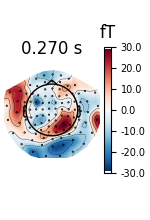

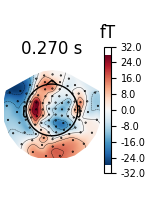

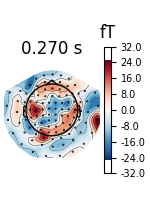

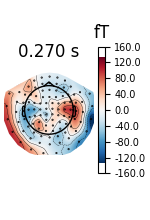

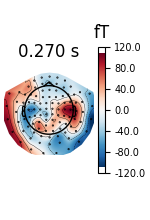

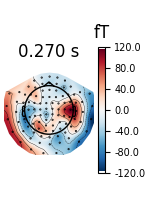

In [26]:
# Topographic maps for neighboring PAS differences

# Topomap for PAS differences
for comp, ev in grand_diffs.items():
    fig = mne.viz.plot_evoked_topomap(
        evoked=ev,
        times=0.27,
        ch_type='mag',
        show=True
    )
    fig.savefig(join(output_dir, f"GrandAvg_{comp}_Diff_Topomap_270ms.png"), dpi=300)
    plt.close(fig)

# Topomap for each PAS condition
for pas_name, ev in grand_avgs.items():
    fig = mne.viz.plot_evoked_topomap(
        evoked=ev,
        times=0.27,
        ch_type='mag',
        show=True
    )
    fig.savefig(join(output_dir, f"GrandAvg_{pas_name}_Topomap_270ms.png"), dpi=300)
    plt.close(fig)


Reading /work/MatildaSifRhys-Kristensen#5883/Portfolio/plots_PAS_sanity/0163/0163_evokeds-ave.fif ...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203) active
        planar-Raw-0.000-120.000-PCA-02 (1 x 203) active
        planar-Raw-0.000-120.000-PCA-03 (1 x 203) active
        axial-Raw-0.000-120.000-PCA-01 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-02 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-03 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-04 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-05 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-06 (1 x 102) active
    Found the data of interest:
        t =    -200.00 ...     550.00 ms (PAS1)
        0 CTF compensation matrices available
        nave = 56 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Loaded Evoked data is baseline-corrected (baseline: [-0.2, 0] s)
    Read a total of 9 projection items:
        pla

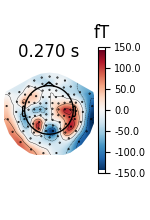

Saved PAS-mean topomap for 0163: plots_PAS_sanity/0163_PASmean_Topomap.png
Reading /work/MatildaSifRhys-Kristensen#5883/Portfolio/plots_PAS_sanity/0164/0164_evokeds-ave.fif ...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203) active
        planar-Raw-0.000-120.000-PCA-02 (1 x 203) active
        planar-Raw-0.000-120.000-PCA-03 (1 x 203) active
        axial-Raw-0.000-120.000-PCA-01 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-02 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-03 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-04 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-05 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-06 (1 x 102) active
    Found the data of interest:
        t =    -200.00 ...     550.00 ms (PAS1)
        0 CTF compensation matrices available
        nave = 55 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Loaded Evoked data is baseline-corrected 

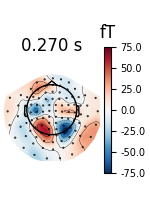

Saved PAS-mean topomap for 0164: plots_PAS_sanity/0164_PASmean_Topomap.png
Reading /work/MatildaSifRhys-Kristensen#5883/Portfolio/plots_PAS_sanity/0165/0165_evokeds-ave.fif ...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203) active
        planar-Raw-0.000-120.000-PCA-02 (1 x 203) active
        planar-Raw-0.000-120.000-PCA-03 (1 x 203) active
        axial-Raw-0.000-120.000-PCA-01 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-02 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-03 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-04 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-05 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-06 (1 x 102) active
    Found the data of interest:
        t =    -200.00 ...     550.00 ms (PAS1)
        0 CTF compensation matrices available
        nave = 39 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Loaded Evoked data is baseline-corrected 

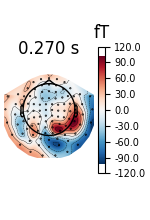

Saved PAS-mean topomap for 0165: plots_PAS_sanity/0165_PASmean_Topomap.png
Reading /work/MatildaSifRhys-Kristensen#5883/Portfolio/plots_PAS_sanity/0166/0166_evokeds-ave.fif ...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203) active
        planar-Raw-0.000-120.000-PCA-02 (1 x 203) active
        planar-Raw-0.000-120.000-PCA-03 (1 x 203) active
        axial-Raw-0.000-120.000-PCA-01 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-02 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-03 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-04 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-05 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-06 (1 x 102) active
    Found the data of interest:
        t =    -200.00 ...     550.00 ms (PAS1)
        0 CTF compensation matrices available
        nave = 33 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Loaded Evoked data is baseline-corrected 

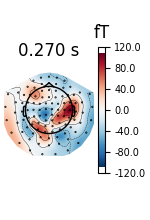

Saved PAS-mean topomap for 0166: plots_PAS_sanity/0166_PASmean_Topomap.png
Reading /work/MatildaSifRhys-Kristensen#5883/Portfolio/plots_PAS_sanity/0167/0167_evokeds-ave.fif ...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203) active
        planar-Raw-0.000-120.000-PCA-02 (1 x 203) active
        planar-Raw-0.000-120.000-PCA-03 (1 x 203) active
        axial-Raw-0.000-120.000-PCA-01 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-02 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-03 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-04 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-05 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-06 (1 x 102) active
    Found the data of interest:
        t =    -200.00 ...     550.00 ms (PAS1)
        0 CTF compensation matrices available
        nave = 51 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Loaded Evoked data is baseline-corrected 

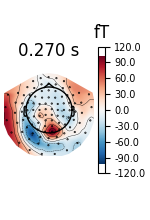

Saved PAS-mean topomap for 0167: plots_PAS_sanity/0167_PASmean_Topomap.png
Reading /work/MatildaSifRhys-Kristensen#5883/Portfolio/plots_PAS_sanity/0168/0168_evokeds-ave.fif ...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203) active
        planar-Raw-0.000-120.000-PCA-02 (1 x 203) active
        planar-Raw-0.000-120.000-PCA-03 (1 x 203) active
        axial-Raw-0.000-120.000-PCA-01 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-02 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-03 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-04 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-05 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-06 (1 x 102) active
    Found the data of interest:
        t =    -200.00 ...     550.00 ms (PAS1)
        0 CTF compensation matrices available
        nave = 57 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Loaded Evoked data is baseline-corrected 

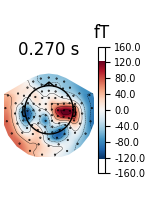

Saved PAS-mean topomap for 0168: plots_PAS_sanity/0168_PASmean_Topomap.png
Reading /work/MatildaSifRhys-Kristensen#5883/Portfolio/plots_PAS_sanity/0169/0169_evokeds-ave.fif ...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203) active
        planar-Raw-0.000-120.000-PCA-02 (1 x 203) active
        planar-Raw-0.000-120.000-PCA-03 (1 x 203) active
        axial-Raw-0.000-120.000-PCA-01 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-02 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-03 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-04 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-05 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-06 (1 x 102) active
    Found the data of interest:
        t =    -200.00 ...     550.00 ms (PAS1)
        0 CTF compensation matrices available
        nave = 35 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Loaded Evoked data is baseline-corrected 

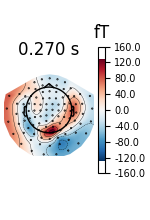

Saved PAS-mean topomap for 0169: plots_PAS_sanity/0169_PASmean_Topomap.png
Reading /work/MatildaSifRhys-Kristensen#5883/Portfolio/plots_PAS_sanity/0170/0170_evokeds-ave.fif ...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203) active
        planar-Raw-0.000-120.000-PCA-02 (1 x 203) active
        planar-Raw-0.000-120.000-PCA-03 (1 x 203) active
        axial-Raw-0.000-120.000-PCA-01 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-02 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-03 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-04 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-05 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-06 (1 x 102) active
    Found the data of interest:
        t =    -200.00 ...     550.00 ms (PAS1)
        0 CTF compensation matrices available
        nave = 59 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Loaded Evoked data is baseline-corrected 

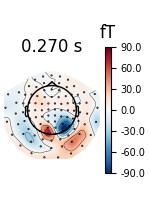

Saved PAS-mean topomap for 0170: plots_PAS_sanity/0170_PASmean_Topomap.png


In [27]:
# Per-participant topographic joint plots (collapsed across PAS conditions)

for sub_id in subject_ids:
    evokeds = mne.read_evokeds(os.path.join(output_dir, sub_id, f"{sub_id}_evokeds-ave.fif"))
    
    # Select PAS-related evokeds
    pas_evokeds = [ev for ev in evokeds if ev.comment in ['PAS1', 'PAS2', 'PAS3']]
    
    if len(pas_evokeds) == 0:
        print(f"No PAS evokeds found for {sub_id}, skipping.")
        continue
    
    # Compute average across PAS conditions
    evoked_avg = mne.grand_average(evokeds)
    evoked_avg.comment = "PAS_mean"
    
    # Pick magnetometers only
    ev_mag = evoked_avg.copy().pick('mag')
    
    # Plot joint evoked topomap
    fig = mne.viz.plot_evoked_topomap(
        ev_mag,
        times= 0.27,
        show=True
    )
    
    # Save figure
    fig_path = os.path.join(output_dir, f"{sub_id}_PASmean_Topomap.png")
    fig.savefig(fig_path, dpi=300)
    plt.close(fig)
    
    print(f"Saved PAS-mean topomap for {sub_id}: {fig_path}")


['MEG0111', 'MEG0112', 'MEG0113', 'MEG0121', 'MEG0122', 'MEG0123', 'MEG0131', 'MEG0132', 'MEG0133', 'MEG0141', 'MEG0142', 'MEG0143', 'MEG0211', 'MEG0212', 'MEG0213', 'MEG0221', 'MEG0222', 'MEG0223', 'MEG0231', 'MEG0232']


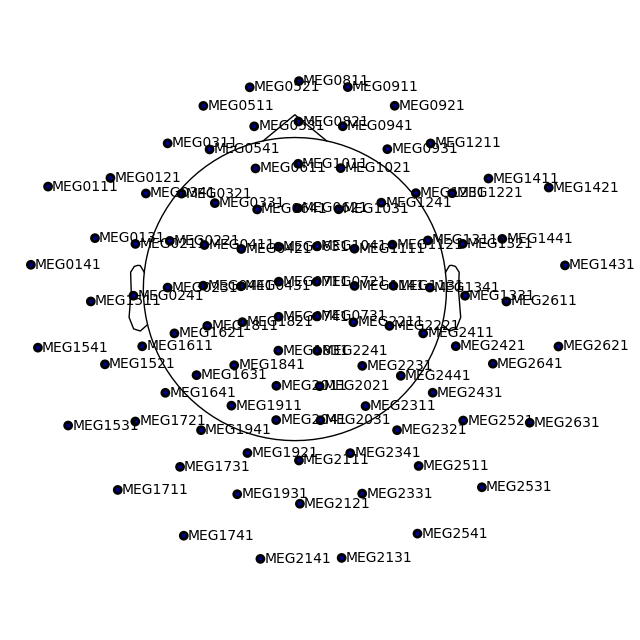

In [13]:
# Select Channel names
print(ev.info['ch_names'][:20])  # see first 20 channel names

# see sensor map
ev.plot_sensors(kind='topomap', show_names=True);

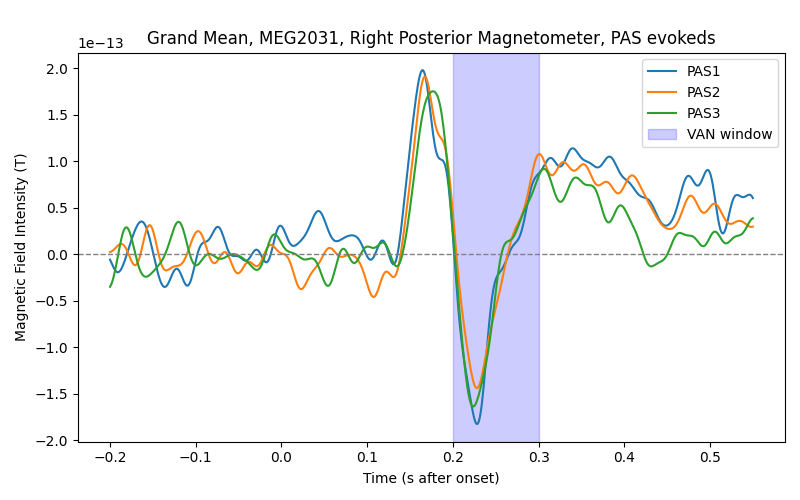

In [28]:
# VAN - sanity check:

# Occipital magnetometers
picks = mne.pick_channels(ev.info['ch_names'], include=['MEG2031'])

# 2031, 2021,2311, 2231, 2441 - selected as a clump from the plot above. 

# Create figure
fig, ax = plt.subplots(figsize=(8, 5))

for cond, evoked in evokeds_dict.items():  # evokeds_dict contains PAS evokeds per subject
    # pick channels and average across them
    data = evoked.data[picks, :].mean(axis=0)  # 1D array across time
    ax.plot(evoked.times, data, label=cond) # plot mangetic field

# Highlight VAN window (~200–300 ms)
ax.axvspan(0.2, 0.3, color='blue', alpha=0.2, label='VAN window')
ax.axhline(0, color='grey', linestyle='--', linewidth=1)
ax.set_xlabel('Time (s after onset)')
ax.set_ylabel('Magnetic Field Intensity (T)')
ax.set_title('Grand Mean, MEG2031, Right Posterior Magnetometer, PAS evokeds')
legend = ax.legend(loc='best', frameon=True)
legend.get_frame().set_alpha(0.9) 
fig_path = os.path.join(output_dir, "Posterior_VAN_PAS_evokeds.png")
fig.savefig(fig_path, dpi=300)
ax.legend()

plt.tight_layout()
plt.show()




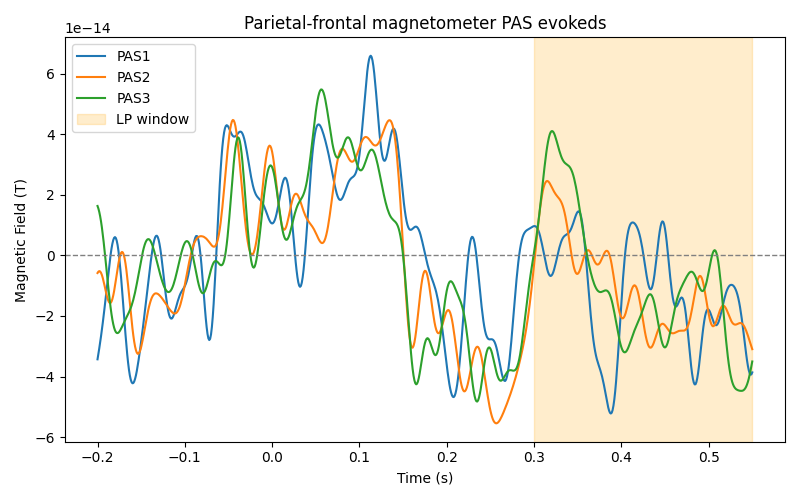

Grand average plots saved.


In [29]:
# LP P3 component - sanity check:

# Parietla-frontal magnetometers
picks = mne.pick_channels(ev.info['ch_names'], include=['MEG0731','MEG2211'])

# Create figure
fig, ax = plt.subplots(figsize=(8, 5))

for cond, evoked in evokeds_dict.items():  # evokeds_dict contains PAS evokeds per subject
    # pick channels and average across them
    data = evoked.data[picks, :].mean(axis=0)  # 1D array across time
    ax.plot(evoked.times, data, label=cond) # plot mangetic field

# Highlight LP window (~300–550 ms)
ax.axvspan(0.3, 0.55, color='orange', alpha=0.2, label='LP window')
ax.axhline(0, color='grey', linestyle='--', linewidth=1)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Magnetic Field (T)')
ax.set_title('Parietal-frontal magnetometer PAS evokeds')
ax.legend()

plt.tight_layout()
fig_path = os.path.join(output_dir, "Parietal_Frontal_PAS_evokeds.png")
fig.savefig(fig_path, dpi=300)
plt.show()


print("Grand average plots saved.")


In [49]:
# Function to plot Per participant for VAN and LP
import math

def plot_component_per_subject(component_name, channel_list, time_window, pas_codes=['100','200','300']):
    """
    Plot line plots of evoked responses per subject side by side for a given component.

    Parameters
    ----------
    component_name : str
        Name of the component (e.g., 'VAN' or 'LP') used for titles and saving.
    channel_list : list of str
        Channels to include in the average.
    time_window : tuple
        Time window to highlight (start, end) in seconds.
    pas_codes : list of str
        PAS codes to plot.
    """
    output_dir_comp = os.path.join(output_dir, f"{component_name}_PerSubject")
    os.makedirs(output_dir_comp, exist_ok=True)

    n_subjects = len(subject_ids)

    n_rows = 2
    n_cols = math.ceil(n_subjects / n_rows)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows), sharey=True)
    axes = axes.flatten()


    for i, sub_id in enumerate(subject_ids):
        # Load subject evokeds
        evokeds = mne.read_evokeds(os.path.join(output_dir, sub_id, f"{sub_id}_evokeds-ave.fif"))
        evokeds_dict = {ev.comment: ev for ev in evokeds if ev.comment in ['PAS1','PAS2','PAS3']}

        ax = axes[i]
        picks = mne.pick_channels(evokeds[0].info['ch_names'], include=channel_list)

        for cond, ev in evokeds_dict.items():
            data = ev.data[picks, :].mean(axis=0)
            ax.plot(ev.times, data, label=cond)

        # Highlight time window
        ax.axvspan(time_window[0], time_window[1], color='blue' if component_name=='VAN' else 'orange', alpha=0.2)
        ax.axhline(0, color='grey', linestyle='--', linewidth=1)
        ax.set_xlabel('Time (s after stimulus onset)')
        if i == 0:
            ax.set_ylabel('Magnetic Field Intensity (T)')
        ax.set_title(sub_id)
        ax.grid(True)

    fig.suptitle(f'{van_channels} - {component_name} - PAS evokeds per Subject', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    fig_path = os.path.join(output_dir, f"{component_name}_PAS_evokeds_PerSubject.png")
    fig.savefig(fig_path, dpi=300)
    plt.close(fig)
    print(f"Saved {component_name} per-subject figure: {fig_path}")



In [50]:
# IMPLEMENTATION PER PARTICIPANT

# VAN 
van_channels = ['MEG2031']
plot_component_per_subject('VAN', van_channels, time_window=(0.2, 0.3))

# LP
lp_channels = ['MEG2211','MEG0731']
plot_component_per_subject('LP', lp_channels, time_window=(0.3, 0.45))

Reading /work/MatildaSifRhys-Kristensen#5883/Portfolio/plots_PAS_sanity/0163/0163_evokeds-ave.fif ...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203) active
        planar-Raw-0.000-120.000-PCA-02 (1 x 203) active
        planar-Raw-0.000-120.000-PCA-03 (1 x 203) active
        axial-Raw-0.000-120.000-PCA-01 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-02 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-03 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-04 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-05 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-06 (1 x 102) active
    Found the data of interest:
        t =    -200.00 ...     550.00 ms (PAS1)
        0 CTF compensation matrices available
        nave = 56 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Loaded Evoked data is baseline-corrected (baseline: [-0.2, 0] s)
    Read a total of 9 projection items:
        pla

In [32]:
# GFP across all PAS conditions (collapsed) for selected channels
roi_channels = ['MEG2041', 'MEG2031', 'MEG2111', 'MEG2341', 
                'MEG2121', 'MEG2331', 'MEG2131', 'MEG2541', 'MEG2141']

fig, ax = plt.subplots(figsize=(8, 5))

# Collect and average evoked data across PAS before computing GFP
all_data = []  # list of arrays: (n_channels, n_times)

for cond, evoked in evokeds_dict.items():
    picks = mne.pick_channels(evoked.info['ch_names'], include=roi_channels)
    all_data.append(evoked.data[picks, :])

# Stack and average across PAS conditions → shape: (n_channels, n_times)
mean_data = np.mean(np.stack(all_data), axis=0)

# Compute GFP across channels
mean_gfp = np.sqrt(np.mean(mean_data**2, axis=0))
times = list(evokeds_dict.values())[0].times

# Plot only the mean GFP line
ax.plot(times, mean_gfp, color='black', linewidth=2, label='Mean GFP (collapsed across PAS)')

# Highlight windows
ax.axvspan(0.3, 0.55, color='orange', alpha=0.2, label='LP window')
ax.axvspan(0.20, 0.30, color='cyan', alpha=0.2, label='VAN window')

# Formatting
ax.axhline(0, color='grey', linestyle='--', linewidth=1)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Regional Global Field Power (T)')
ax.set_title('Regional GFP (Collapsed Across PAS Conditions)')
ax.legend()
plt.tight_layout()

# Save
fig_path = os.path.join(output_dir, "Mean_Regional_GFP.png")
fig.savefig(fig_path, dpi=300)
plt.close(fig)
print(f"Saved mean regional GFP plot: {fig_path}")


Saved mean regional GFP plot: plots_PAS_sanity/Mean_Regional_GFP.png
